<a href="https://colab.research.google.com/github/giovanirojascuela/2025_5TO01/blob/main/TALLER/EVALUACION/QUISPE_SUCARI_LAURENS_EVA_PARTE01ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# 1. Subida de archivos desde el equipo
from google.colab import files
uploaded = files.upload()  # Subir index_1.csv y index_2.csv


Saving index_1.csv to index_1.csv
Saving index_2.csv to index_2.csv


In [4]:
# 2. Carga y combinación de los datasets
import pandas as pd

df1 = pd.read_csv("index_1.csv")
df2 = pd.read_csv("index_2.csv")

# Eliminar columna 'card' para unificar estructura
df1 = df1.drop(columns=["card"])

# Unir ambos datasets
df = pd.concat([df1, df2], ignore_index=True)
df["datetime"] = pd.to_datetime(df["datetime"], format='mixed', errors='coerce')

df["date"] = pd.to_datetime(df["date"])


In [5]:
# 3. Ingeniería de características
df["month"] = df["datetime"].dt.month
df["day_of_week"] = df["datetime"].dt.dayofweek
df["hour"] = df["datetime"].dt.hour


In [6]:
# 4. Crear variable objetivo: cantidad_total_vendida_no_dia
ventas_diarias = df.groupby("date")["money"].sum().reset_index(name="cantidad_total_vendida_no_dia")


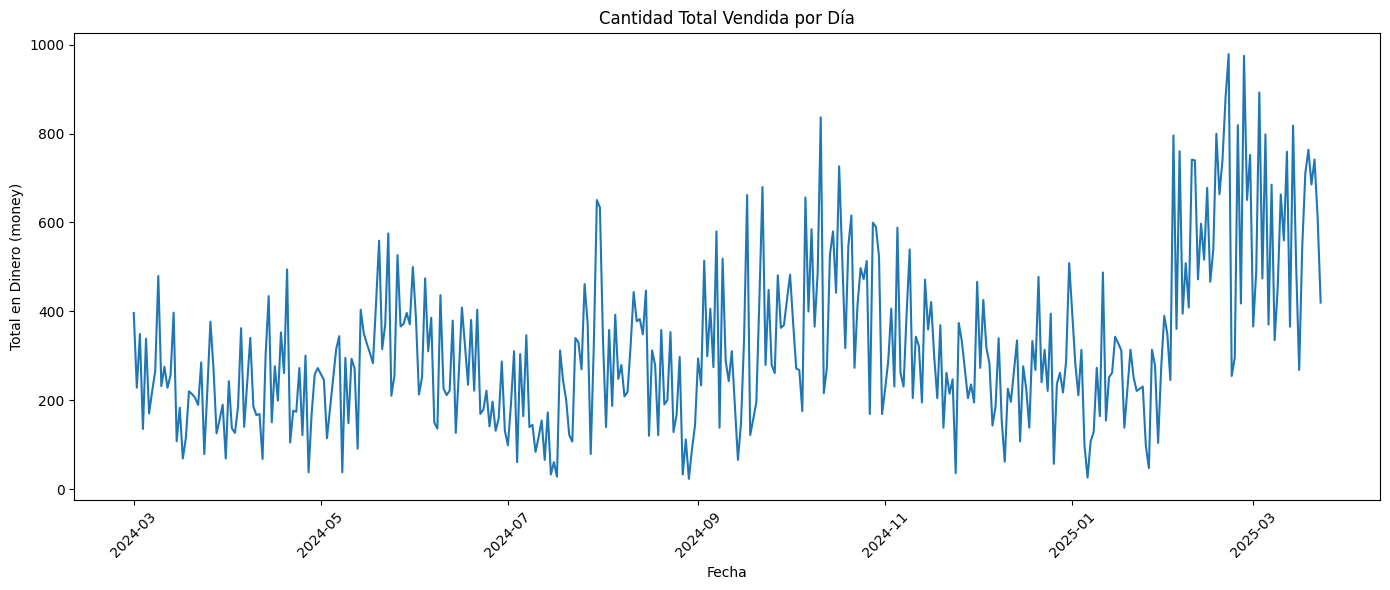

In [7]:
# 5. Visualización de ventas por día
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14,6))
sns.lineplot(data=ventas_diarias, x="date", y="cantidad_total_vendida_no_dia")
plt.title("Cantidad Total Vendida por Día")
plt.xlabel("Fecha")
plt.ylabel("Total en Dinero (money)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


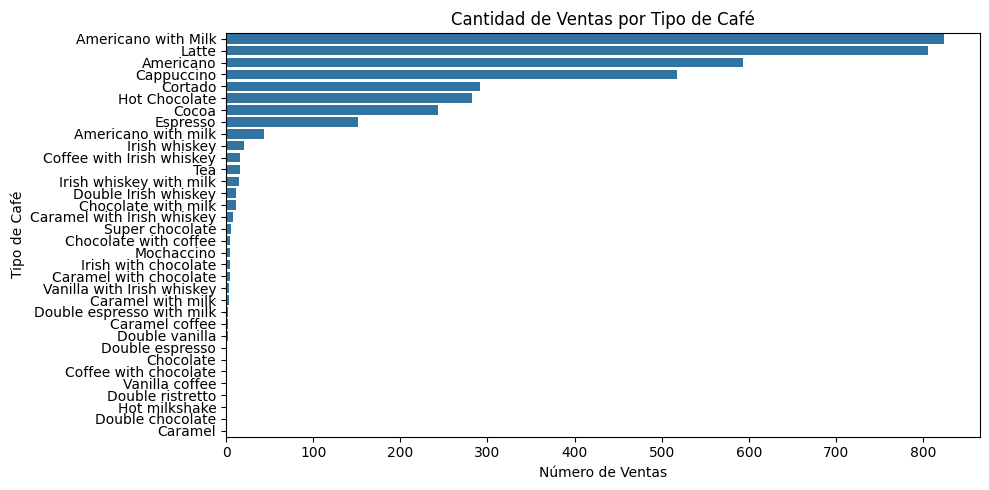

In [8]:
# 6. Visualización de ventas por tipo de café
plt.figure(figsize=(10,5))
sns.countplot(data=df, y="coffee_name", order=df["coffee_name"].value_counts().index)
plt.title("Cantidad de Ventas por Tipo de Café")
plt.xlabel("Número de Ventas")
plt.ylabel("Tipo de Café")
plt.tight_layout()
plt.show()


In [11]:
# Agrupar X por día para que coincida con ventas_diarias
X_features = df.groupby("date")[["month", "day_of_week", "hour"]].mean().reset_index()

# Unir con y (ventas_diarias)
dataset = pd.merge(ventas_diarias, X_features, on="date")

# Preparar X e y finales
X = dataset[["month", "day_of_week", "hour"]]
y = dataset["cantidad_total_vendida_no_dia"]

# Escalado
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)



In [12]:
# Entrenamiento con TensorFlow Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Definir el modelo secuencial
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)  # Salida continua
])

# Compilar el modelo
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Entrenar el modelo
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=16,
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 145281.5625 - mae: 324.4027 - val_loss: 130376.3281 - val_mae: 322.4961
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 134357.2188 - mae: 322.0732 - val_loss: 129828.5703 - val_mae: 321.6382
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 139786.2500 - mae: 324.9319 - val_loss: 129038.9297 - val_mae: 320.3990
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 138694.7500 - mae: 319.9137 - val_loss: 127910.7969 - val_mae: 318.6093
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 144129.4531 - mae: 326.8103 - val_loss: 126289.2188 - val_mae: 316.0224
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 153083.3125 - mae: 333.4294 - val_loss: 124063.2969 - val_mae: 312.4421
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 144333.6250 - mae: 326.6028 - val_loss: 121143.4922 - val_mae: 307.6747
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 123381.9844 - mae: 297.3696 -

In [13]:
# Realizar predicciones y evaluar con métricas de regresión
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE:  {mae:.2f}")
print(f"MSE:  {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.4f}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
MAE:  139.86
MSE:  32267.84
RMSE: 179.63
R²:   0.0879


In [14]:
# Agrupar: suma de dinero por café y día
df_cafe_dia = df.groupby(["date", "coffee_name"])["money"].sum().unstack(fill_value=0).reset_index()

# Extraer características de fecha (mes, día, hora promedio ese día)
features_dia = df.groupby("date")[["month", "day_of_week", "hour"]].mean().reset_index()

# Unir ambos
df_multi = pd.merge(df_cafe_dia, features_dia, on="date")

# Preparar X (features) e Y (ventas por tipo de café)
X_multi = df_multi[["month", "day_of_week", "hour"]]
Y_multi = df_multi.drop(columns=["date", "month", "day_of_week", "hour"])


In [15]:
# Escalar características
scaler_multi = StandardScaler()
X_multi_scaled = scaler_multi.fit_transform(X_multi)

# Dividir en entrenamiento y prueba
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(
    X_multi_scaled, Y_multi, test_size=0.2, random_state=42
)


In [16]:
# Crear modelo con una salida por tipo de café
model_multi = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_m.shape[1],)),
    Dense(32, activation='relu'),
    Dense(Y_multi.shape[1])  # Una salida por tipo de café
])

model_multi.compile(optimizer='adam', loss='mse', metrics=['mae'])
history_multi = model_multi.fit(
    X_train_m, y_train_m, validation_split=0.2, epochs=50, batch_size=16
)


Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 913.1407 - mae: 9.4501 - val_loss: 959.6548 - val_mae: 9.6114
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 952.5388 - mae: 9.8125 - val_loss: 956.2543 - val_mae: 9.6360
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 995.4733 - mae: 9.8734 - val_loss: 950.8664 - val_mae: 9.6716
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 884.7283 - mae: 9.3714 - val_loss: 942.1116 - val_mae: 9.7055
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 970.6467 - mae: 9.9332 - val_loss: 927.6074 - val_mae: 9.7344
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 890.3427 - mae: 9.7563 - val_loss: 905.4073 - val_mae: 9.7689
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 883.0707 - mae: 9.7302 - val_loss: 873.3218 - val_mae: 9.8217
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 882.5128 - mae: 9.8920 - val_loss: 830.9332 - val_mae: 9.7870
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━

In [17]:
# Predicciones
y_pred_m = model_multi.predict(X_test_m)

# Evaluación por tipo de café
for i, col in enumerate(Y_multi.columns):
    mae = mean_absolute_error(y_test_m.iloc[:, i], y_pred_m[:, i])
    mse = mean_squared_error(y_test_m.iloc[:, i], y_pred_m[:, i])
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_m.iloc[:, i], y_pred_m[:, i])
    print(f"📌 {col} → MAE: {mae:.2f} | RMSE: {rmse:.2f} | R²: {r2:.4f}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step 
📌 Americano → MAE: 37.32 | RMSE: 49.47 | R²: 0.0822
📌 Americano with Milk → MAE: 50.12 | RMSE: 64.62 | R²: 0.0065
📌 Americano with milk → MAE: 6.64 | RMSE: 13.63 | R²: 0.0776
📌 Cappuccino → MAE: 33.97 | RMSE: 40.80 | R²: -0.0689
📌 Caramel → MAE: 0.21 | RMSE: 0.26 | R²: 0.0000
📌 Caramel coffee → MAE: 0.41 | RMSE: 3.18 | R²: -0.0037
📌 Caramel with Irish whiskey → MAE: 2.04 | RMSE: 7.61 | R²: 0.0180
📌 Caramel with chocolate → MAE: 1.06 | RMSE: 4.55 | R²: -0.0417
📌 Caramel with milk → MAE: 0.62 | RMSE: 2.84 | R²: -0.0044
📌 Chocolate → MAE: 0.25 | RMSE: 0.29 | R²: 0.0000
📌 Chocolate with coffee → MAE: 0.89 | RMSE: 1.06 | R²: 0.0000
📌 Chocolate with milk → MAE: 1.96 | RMSE: 5.16 | R²: 0.0251
📌 Cocoa → MAE: 27.76 | RMSE: 34.12 | R²: 0.0219
📌 Coffee with Irish whiskey → MAE: 2.28 | RMSE: 4.62 | R²: -0.0022
📌 Coffee with chocolate → MAE: 0.07 | RMSE: 0.08 | R²: 0.0000
📌 Cortado → MAE: 22.93 | RMSE: 28.95 | R²: -0.0257
📌 Double Irish whiskey → MAE: 2.08 | R

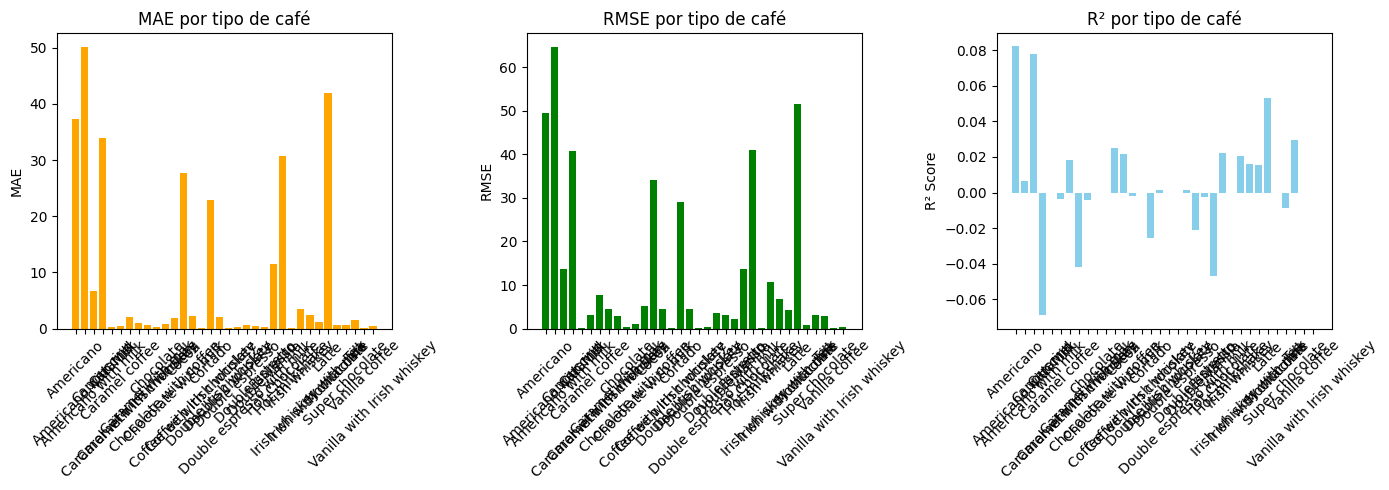

In [18]:
import matplotlib.pyplot as plt

# Listas para almacenar métricas
mae_list, rmse_list, r2_list = [], [], []

# Calcular métricas por tipo de café
for i, col in enumerate(Y_multi.columns):
    mae = mean_absolute_error(y_test_m.iloc[:, i], y_pred_m[:, i])
    mse = mean_squared_error(y_test_m.iloc[:, i], y_pred_m[:, i])
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_m.iloc[:, i], y_pred_m[:, i])

    mae_list.append(mae)
    rmse_list.append(rmse)
    r2_list.append(r2)

# Crear gráfico de barras para cada métrica
labels = list(Y_multi.columns)
x = range(len(labels))

plt.figure(figsize=(14, 5))

# MAE
plt.subplot(1, 3, 1)
plt.bar(x, mae_list, color='orange')
plt.xticks(x, labels, rotation=45)
plt.title('MAE por tipo de café')
plt.ylabel('MAE')

# RMSE
plt.subplot(1, 3, 2)
plt.bar(x, rmse_list, color='green')
plt.xticks(x, labels, rotation=45)
plt.title('RMSE por tipo de café')
plt.ylabel('RMSE')

# R²
plt.subplot(1, 3, 3)
plt.bar(x, r2_list, color='skyblue')
plt.xticks(x, labels, rotation=45)
plt.title('R² por tipo de café')
plt.ylabel('R² Score')

plt.tight_layout()
plt.show()


In [23]:
# Guardar modelo de ventas totales por día
model.compile(optimizer='adam', loss='mean_squared_error')


# Guardar modelo de ventas por tipo de café
model_multi.save("modelo_por_tipo.h5")


In [24]:
import joblib

# Guardar el escalador para el modelo total
joblib.dump(scaler, "scaler_total.pkl")

# Guardar el escalador para el modelo por tipo
joblib.dump(scaler_multi, "scaler_tipo.pkl")


['scaler_tipo.pkl']

In [25]:
from google.colab import files

# Descargar los archivos uno por uno
files.download("modelo_total_diario.h5")
files.download("modelo_por_tipo.h5")
files.download("scaler_total.pkl")
files.download("scaler_tipo.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>